In [1]:
from hypernetworks.core.Hypernetwork import Hypernetwork
from hypernetworks.core.Hypersimplex import VERTEX, ALPHA, BETA, PROPERTY, UNION_ALPHA, IMMUTABLE_ALPHA, SEQUENCE, hstype_to_str
from hypernetworks.utils.HTCompiler import load_parser, compile_hn
from hypernetworks.utils.HTGraph import draw_hn

from IPython.display import Image, display

from graphviz import nohtml

import graphviz
import pprint as pp
import re
import textwrap
import iplantuml

pictures_dir = "pictures/C4/"
parser = load_parser()

Matplotlib is building the font cache; this may take a moment.


In [2]:
lookup={
    "customer":               {"C": "context", "title": "Personal Banking Customer", "stereotype": "Person", "description": "A customer of the bank, with personal bank accounts."},
    "ibs":                    {"C": "context", "title": "Internet Banking System", "stereotype": "Software System", "description": "Allows customers to view information about their bank accounts, and make payments."},
    "mainframe":              {"C": "context", "title": "Mainframe Banking System", "stereotype": "Software System", "description": "Stores all of the core banking infrormation about customers, accounts, transaction etc."},
    "email":                  {"C": "context", "title": "E-mail System", "stereotype": "Software System", "description": "The internal Microsoft Exchange e-mail system."},
   
    "view-account-agg":           {"label": "Views account balances, and makes payments using"},
    "view-account-mainframe-agg": {"label": "Gets account information from, and makes payments using"},
    "send-email-cust-agg":        {"label": "Sends e-mail to"},
    "send-ibs-email-agg":         {"label": "Sends e-mail using"},
    
    "web-app":                {"C": "container", "title": "Web Application", "stereotype": "Container: Java and Sprint MVC", "description": "Delivers and static content and the Internet banking single page appliation."},
    "spa":                    {"C": "container", "title": "Single-Page Application", "stereotype": "Container: JavaScript and Angular", "description": "Provides all of the Internet banking functionality to customers via their web browser."},
    "database":               {"C": "container", "title": "Database", "stereotype": "Container: Oracle Database Schema", "description": "Stores user registration information, hashed authentication credentials, access logs etc."},
    "mob-app":                {"C": "container", "title": "Mobile App", "stereotype": "Container: Xamarin", "description": "Provides a limited subset of the Internet banking functionality to customers via their mobile device."},
    "api":                    {"C": "container", "title": "API Application", "stereotype": "Container: Java and Spring MVC", "description": "Provides Internet banking functionality via a JSON/HTTPS API."},
    
    "visit-bank":             {"label": "Visits bigbank.com/ib using", "stereotype": "HTTPS"},
    "view-account-spa":       {"label": "Views account balances, and makes payments", "stereotype": ""},
    "view-account-mob-app":   {"label": "Views account balances, and makes payments", "stereotype": ""},
    "deliver-to-spa":         {"label": "Delivers to the customer's web browser", "stereotype": ""},
    "make-spa-api-call":      {"label": "Make API call to", "stereotype": "JSON/HTTPS"},
    "make-mob-app-api-call":  {"label": "Make API call to", "stereotype": "JSON/HTTPS"},
    "read-db":                {"label": "Reads from and writes to", "stereotype": "JDBC"},
    "send-email":             {"label": "Sends e-mail using", "stereotype": "SMTP"},
    "send-email-cust":        {"label": "Sends e-mail to", "stereotype": ""},
    "call-mainframe":         {"label": "Makes API calls to", "stereotype": "XML/HTPTS"},
    "visit-bank-ret":         {"label": "Redirect to SPA", "stereotype": "HTTPS"}
}

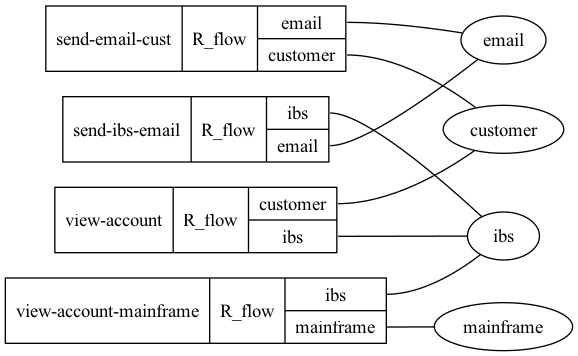

In [3]:
ibs_context = Hypernetwork()

compile_hn(ibs_context, parser, """
    view-account =           <customer, ibs; R_flow>[N3]
    view-account-mainframe = <ibs, mainframe; R_flow>[N3]
    send-ibs-email =         <ibs, email; R_flow>[N3]
    send-email-cust =        <email, customer; R_flow>[N3]
""")

draw_hn(ibs_context, fname=pictures_dir+"ibs-context-hn", view=False, direction="LR", split_camel=False)
Image(filename=pictures_dir+"ibs-context-hn.png", width=400, height=500)

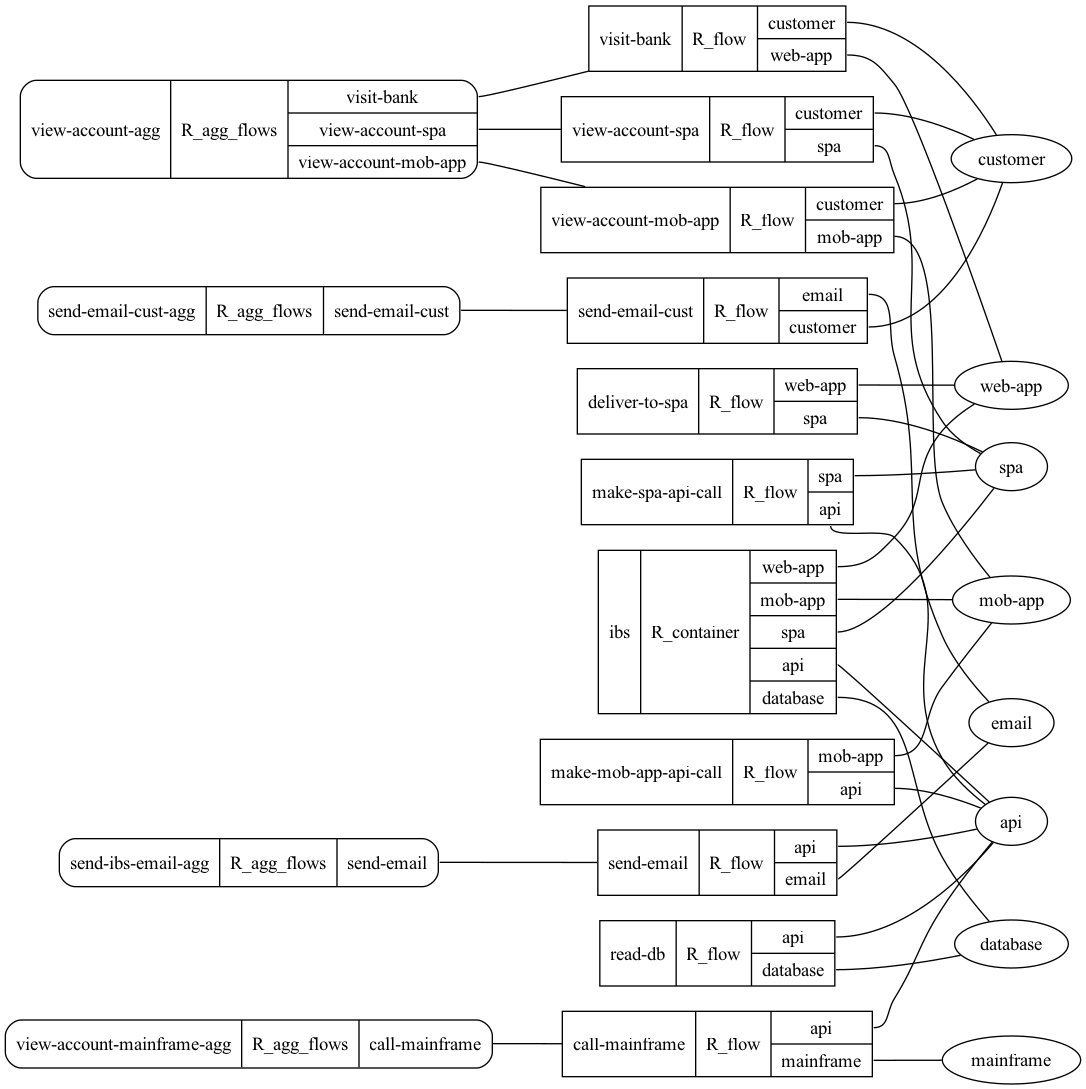

In [4]:
ibs_container = Hypernetwork()

compile_hn(ibs_container, parser, """
    ibs=<web-app, mob-app, spa, api, database; R_container>[N2]
    
    send-ibs-email-agg =         {send-email; R_agg_flows}[N2]
    view-account-agg =           {visit-bank, view-account-spa, view-account-mob-app; R_agg_flows}[N2]
    view-account-mainframe-agg = {call-mainframe; R_agg_flows}[N2]
    send-email-cust-agg =        {send-email-cust; R_agg_flows}[N2]
    
    visit-bank =             <customer, web-app; R_flow>[N1]
    view-account-spa =       <customer, spa; R_flow>[N1]
    view-account-mob-app =   <customer, mob-app; R_flow>[N1]
    deliver-to-spa =         <web-app, spa; R_flow>[N1]
    make-spa-api-call =      <spa, api; R_flow>[N1]
    make-mob-app-api-call =  <mob-app, api; R_flow>[N1]
    read-db =                <api, database; R_flow>[N1]
    send-email =             <api, email; R_flow>[N1]
    send-email-cust =        <email, customer; R_flow>[N2]
    call-mainframe =         <api, mainframe; R_flow>[N1]
""")

draw_hn(ibs_container, fname=pictures_dir+"ibs-container-hn", view=False, direction="LR", split_camel=False)
Image(filename=pictures_dir+"ibs-container-hn.png", width=800, height=500)

In [5]:
ibs_api_component = Hypernetwork()

compile_hn(ibs_api_component, parser, """
    flow=<visit-bank, visit-bank-ret, view-account-spa, make-spa-api-call, read-db, read-db-ret, make-spa-api-call-ret, view-account-spa-ret; R_sequence>
    visit-bank-ret=<web-app, customer; R_return>
    view-account-spa-ret=<spa, customer; R_return>
    make-spa-api-call-ret=<api, spa; R_return>
    read-db-ret=<database, api; R_return>
""")

In [6]:
def draw_c4_diagram(hn, lookup=None, show=[], fname="/tmp/diagram", direction="TB"):
    def _add_node(_G, _name):
        if _name in lookup:
            if hn.hypernetwork[_name].R.name != "container":
                label = lookup[_name]["title"] + "\n\n" + \
                        "[" + lookup[_name]["stereotype"] + "]\n\n" + \
                        textwrap.fill(lookup[_name]["description"], max_width_node)

                _G.node(name=_name, shape="rectangle", label=label.replace("\n", "\\n"))

        else:
            if hn.hypernetwork[_name[8:]].R.name != "container":
                _G.attr('node', shape="rectangle")
                _G.node(name=_name, label=_name)

    if not lookup:
        lookup = {}
    
    max_width_node = 30
    max_width_edge = 20
    
    G = graphviz.Digraph(format='png', filename=fname, strict=False,
                         graph_attr={"pad": "1", "nodesep": "1", "ranksep": "1", "rankdir": direction}, 
                         edge_attr={"labelloc": "c", "len": "10"})
    
    G.attr(compound='true')

    for name, hs in hn.hypernetwork.items():
        if hs.R.name == "container" and "containers" in show:
            with G.subgraph(name="cluster_"+name, edge_attr={"labelloc": "c", "len": "10"}) as SG:
                SG.attr(label=lookup[name]["title"] if name in lookup else name)
                
                for node in hs.simplex:
                    _add_node(SG, node)

        if not hs.R.name:
            for node in hs.simplex:
                _add_node(G, node)

    for name, hs in hn.hypernetwork.items():
#         if hs.R.name == "connection" and "connections" in show:
#             _add_node(G, hs.simplex[0])
#             _add_node(G, hs.simplex[1])

#             if name in lookup:
#                 G.attr('edge', style="dotted", arrowhead="vee")
#                 G.edge(hs.simplex[0], hs.simplex[1], label=textwrap.fill(lookup[name]["label"], max_width_edge))

#             else:
#                 G.attr('edge', style="dotted", arrowhead="vee")
#                 G.edge(hs.simplex[0], hs.simplex[1], label=name)

        if hs.R.name == "flow" and "flows" in show:
            if hn.hypernetwork[hs.simplex[0]].R.name == "container" and "containers" in show:
                _from = "cluster_" + hs.simplex[0]
            
            else:
                _from = hs.simplex[0]
                _add_node(G, _from)

            if hn.hypernetwork[hs.simplex[1]].R.name == "container" and "containers" in show:
                _to = "cluster_" + hs.simplex[1]

            else:
                _to = hs.simplex[1]
                _add_node(G, _to)
            
            label = textwrap.fill(lookup[name]["label"], max_width_edge) if name in lookup else name
            
            G.attr('edge', style="solid", arrowhead="normal")
            G.edge(_from, _to, label=label)

    G.render()

In [7]:
# draw_c4_diagram(ibs_context, lookup, show=["flows"], fname="/tmp/ibs-context")
# Image(filename='/tmp/ibs-context.png', width=800, height=500)

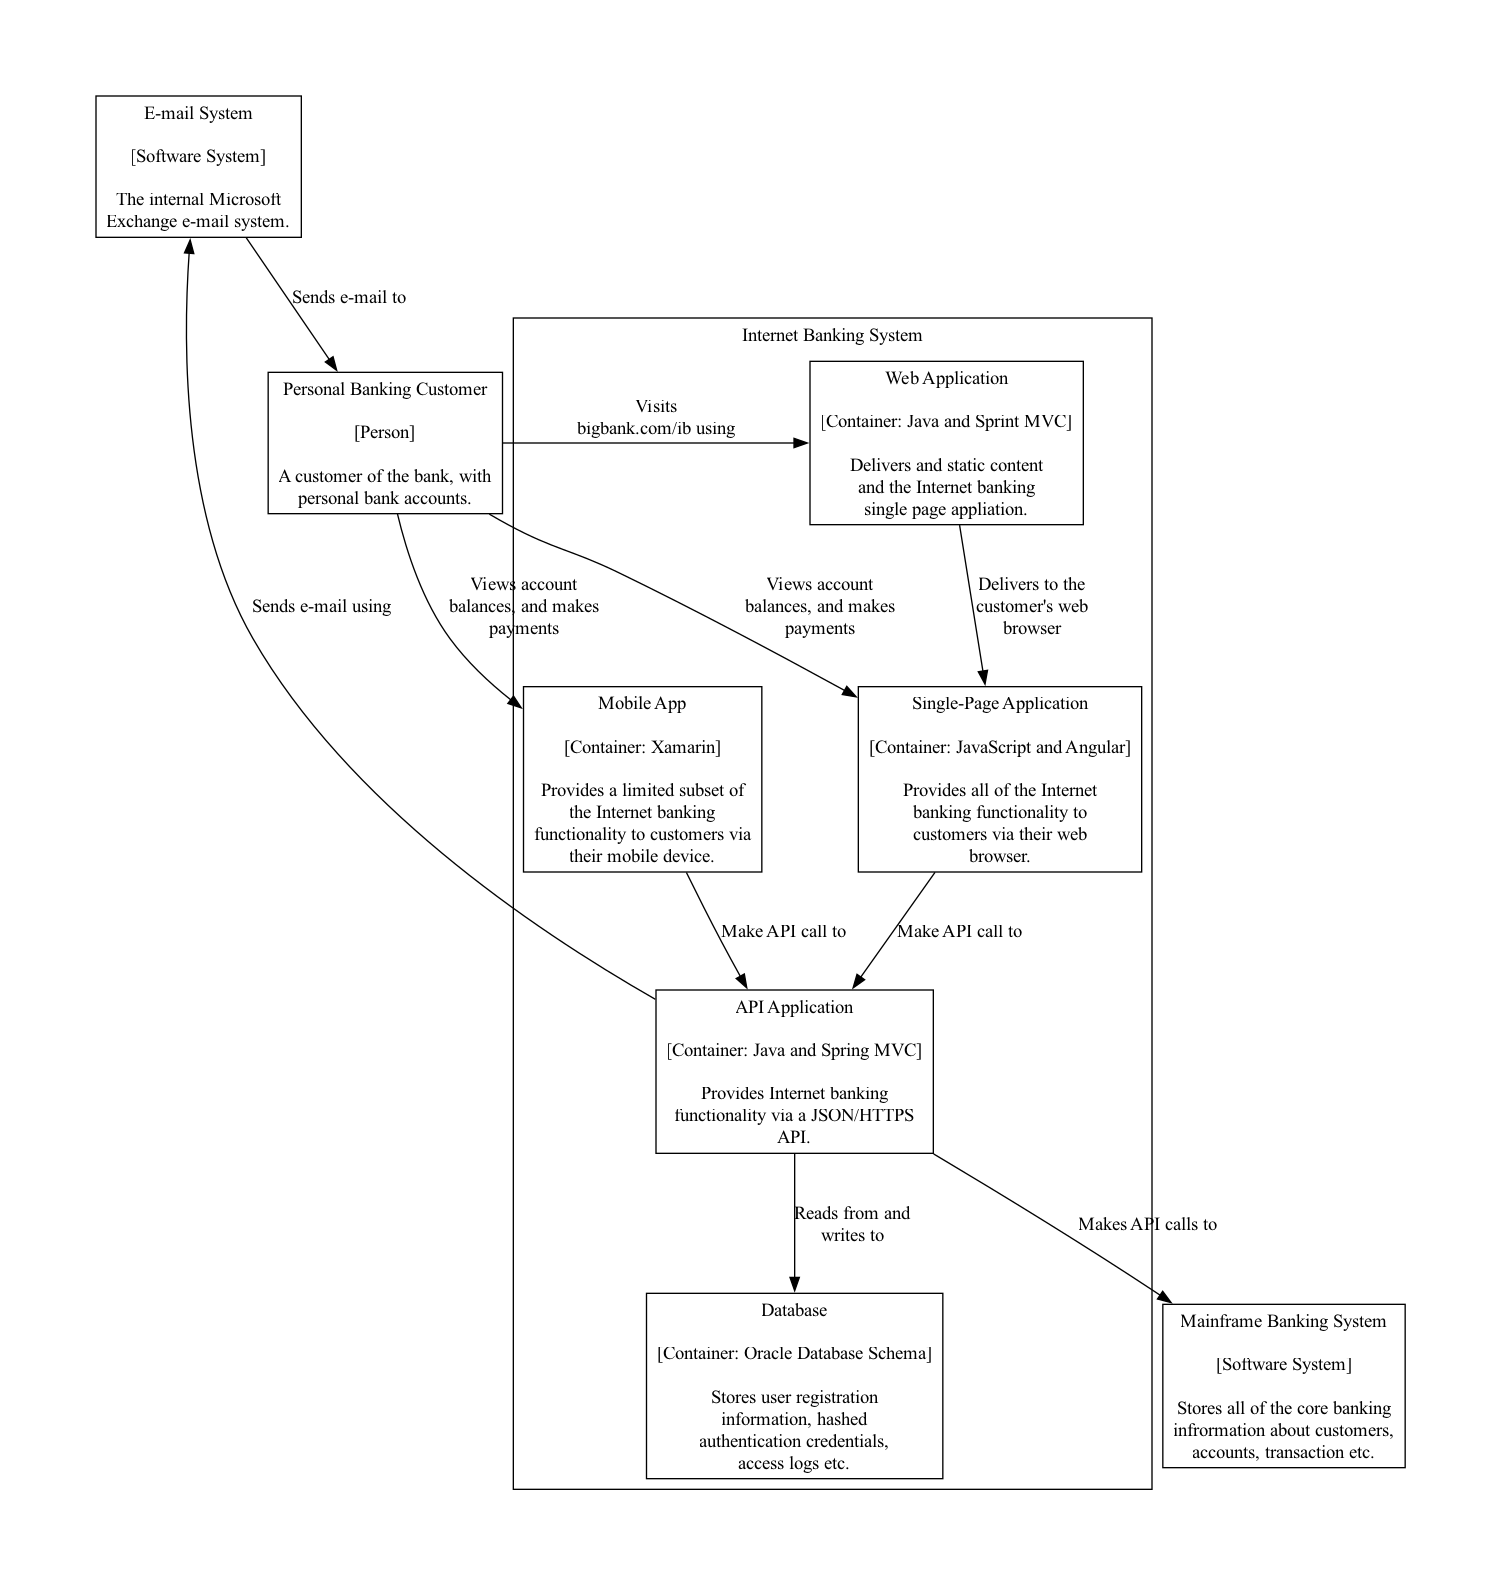

In [8]:
draw_c4_diagram(ibs_container, lookup, show=["flows", "containers"], fname=pictures_dir+"ibs-container")
Image(filename=pictures_dir+"ibs-container.png", width=800, height=500)

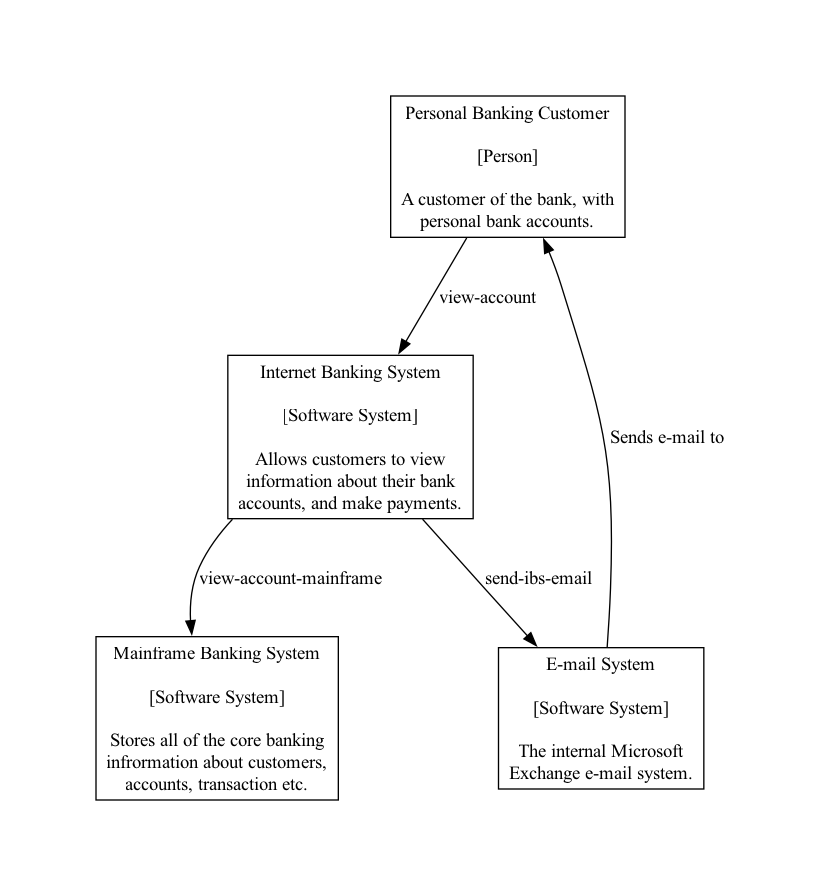

In [9]:
ibs = Hypernetwork()

ibs.union(ibs_context)
# ibs.union(ibs_container)

# print(ibs)

draw_c4_diagram(ibs, lookup, show=["flows", "containers"], fname=pictures_dir+"ibs-context")
Image(filename=pictures_dir+"ibs-context.png", width=800, height=500)

In [10]:
# draw_hn(ibs, fname="/tmp/ibs-hn", view=False, direction="LR", split_camel=False)
# Image(filename='/tmp/ibs-hn.png', width=800, height=500)

Writing output for /Users/richardcharlesworth/Library/Mobile Documents/com~apple~CloudDocs/My PhD/Experiments/Hora/examples/096e1118-147d-44a5-afb1-85ac2b4055b0.uml to 096e1118-147d-44a5-afb1-85ac2b4055b0.svg


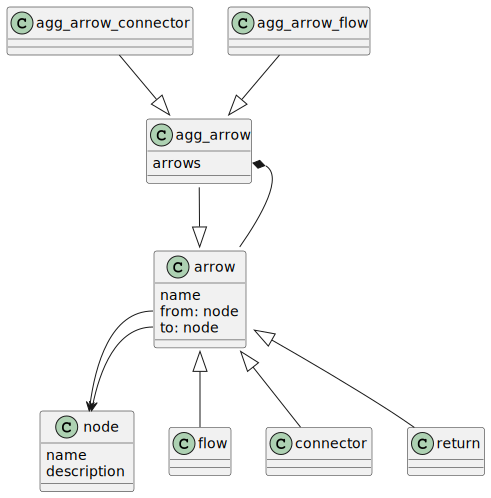

In [11]:
%%plantuml

@startuml
class node {
    {field} name
    {field} description
}

class arrow {
    {field} name
    {field} from: node
    {field} to: node
}

class flow {
}

class connector {
}

arrow <|-- flow
arrow <|-- connector
arrow <|-- return

arrow::from --> node
arrow::to --> node

class agg_arrow {
    {field} arrows
}

agg_arrow_connector --|> agg_arrow
agg_arrow_flow --|> agg_arrow

agg_arrow --|> arrow
agg_arrow::arrows *-- arrow

@enduml

In [12]:
def gen_sequence(hn, seq, lookup):
    res_start = "@startuml"
    res_end = "@enduml"
    
    res = res_start + "\n"
    
    sequence = hn.hypernetwork[seq]

    for v in sequence.simplex:
        hs = hn.hypernetwork[v]

#         frm = hs.simplex[0] if hs.simplex[0] not in lookup else lookup[hs.simplex[0]]["title"].replace(" ", "_").replace("-", "_")
#         to = hs.simplex[1] if hs.simplex[1] not in lookup else lookup[hs.simplex[1]]["title"].replace(" ", "_").replace("-", "_")
#         lbl = hs.vertex if hs.vertex not in lookup else lookup[hs.vertex]["label"]
        frm = hs.simplex[0].replace(" ", "_").replace("-", "_")
        to = hs.simplex[1].replace(" ", "_").replace("-", "_")
        lbl = hs.vertex
        arrow = ""

        if hs.R.name == "flow":
            arrow = " -> "
            
        if hs.R.name == "return":
            arrow = " --> "
            
        res += frm + arrow + to + ": " + lbl + "\n"

    res += res_end
    
    return res

In [13]:
ibs_seq = Hypernetwork()

ibs_seq.union(ibs_container)
ibs_seq.union(ibs_api_component)

# print(ibs_container)
# print(ibs_seq)

# print(ibs_seq.hypernetwork["flow"])
# for k, v in ibs_seq.hypernetwork.items():
    # if v.R.name in ["flow", "return"]:
        # print(v)

print()
print(gen_sequence(ibs_seq, "flow", lookup))


@startuml
customer -> web_app: visit-bank
web_app --> customer: visit-bank-ret
customer -> spa: view-account-spa
spa -> api: make-spa-api-call
api -> database: read-db
database --> api: read-db-ret
api --> spa: make-spa-api-call-ret
spa --> customer: view-account-spa-ret
@enduml


Writing output for /Users/richardcharlesworth/Library/Mobile Documents/com~apple~CloudDocs/My PhD/Experiments/Hora/examples/5a2985de-1904-43fd-a889-f2ea546b0e6b.uml to 5a2985de-1904-43fd-a889-f2ea546b0e6b.svg


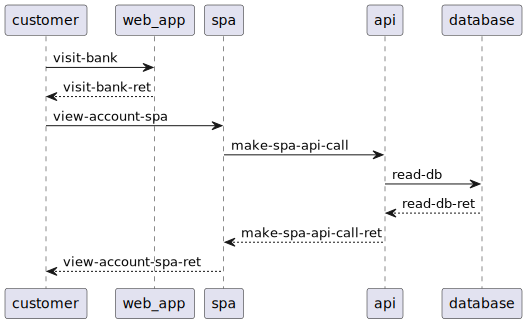

In [14]:
%%plantuml

@startuml
customer -> web_app: visit-bank
web_app --> customer: visit-bank-ret
customer -> spa: view-account-spa
spa -> api: make-spa-api-call
api -> database: read-db
database --> api: read-db-ret
api --> spa: make-spa-api-call-ret
spa --> customer: view-account-spa-ret
@enduml